In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import requests
from io import StringIO
from sklearn.svm import SVC

In [4]:
dataset_url = "https://raw.githubusercontent.com/Mattr5541/data622-assignment-3/refs/heads/main/data/dataset.csv"

response = requests.get(dataset_url, verify=False)  # Disables SSL verification
data = StringIO(response.text)
dataset = pd.read_csv(data)

print(dataset.head())

c:\Users\Black\Documents\GitHub\data622-assignment-3\venv\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'raw.githubusercontent.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


   Hours_Studied  Attendance Parental_Involvement Access_to_Resources  \
0             23          84                  Low                High   
1             19          64                  Low              Medium   
2             24          98               Medium              Medium   
3             29          89                  Low              Medium   
4             19          92               Medium              Medium   

  Extracurricular_Activities  Sleep_Hours  Previous_Scores Motivation_Level  \
0                         No            7               73              Low   
1                         No            8               59              Low   
2                        Yes            7               91           Medium   
3                        Yes            8               98           Medium   
4                        Yes            6               65           Medium   

  Internet_Access  Tutoring_Sessions Family_Income Teacher_Quality  \
0             Ye

In [5]:
mode_teacher_quality = dataset['Teacher_Quality'].mode()[0]

dataset['Teacher_Quality'].fillna(mode_teacher_quality, inplace=True)
dataset['Parental_Education_Level'].fillna('Unknown', inplace=True)
dataset['Distance_from_Home'].fillna('Unknown', inplace=True)

print(dataset.isnull().sum())

Hours_Studied                 0
Attendance                    0
Parental_Involvement          0
Access_to_Resources           0
Extracurricular_Activities    0
Sleep_Hours                   0
Previous_Scores               0
Motivation_Level              0
Internet_Access               0
Tutoring_Sessions             0
Family_Income                 0
Teacher_Quality               0
School_Type                   0
Peer_Influence                0
Physical_Activity             0
Learning_Disabilities         0
Parental_Education_Level      0
Distance_from_Home            0
Gender                        0
Exam_Score                    0
dtype: int64


C:\Users\Black\AppData\Local\Temp\ipykernel_86504\4116957530.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['Teacher_Quality'].fillna(mode_teacher_quality, inplace=True)
C:\Users\Black\AppData\Local\Temp\ipykernel_86504\4116957530.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

In [7]:
threshold = dataset['Exam_Score'].median()
dataset['Exam_Score_Category'] = np.where(dataset['Exam_Score'] >= threshold, 'High', 'Low')

print(dataset[['Exam_Score', 'Exam_Score_Category']].head())

   Exam_Score Exam_Score_Category
0          67                High
1          61                 Low
2          74                High
3          71                High
4          70                High


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
# Use all the variables for X and only Exam_Score for y
X = dataset.drop('Exam_Score', axis=1)
y = dataset['Exam_Score']

# Identify categorical and numerical variables
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

# This will help process numerical variables
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# This will help process categorical variables
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# This transorms different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVC(kernel = "linear"))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Makes the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculates statistics to evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Results
print("Random Forest Model Performance")
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R² Score:", r2)

# Cross-validation scores
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores = (-cv_scores)**0.5
print("Cross-Validation RMSE Scores:", cv_rmse_scores)
print("Mean CV RMSE:", cv_rmse_scores.mean())
print("CV RMSE Std Dev:", cv_rmse_scores.std())



Random Forest Model Performance
Mean Absolute Error: 0.3411497730711044
Mean Squared Error: 4.764750378214826
R² Score: 0.6629129148578914


c:\Users\Black\Documents\GitHub\data622-assignment-3\venv\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Cross-Validation RMSE Scores: [2.48200787 2.44423432 2.12782297 2.2404647  2.67364404]
Mean CV RMSE: 2.393634778729602
CV RMSE Std Dev: 0.1912549583144161


## Support Vector Machine Model 1

First, we will create SVC models similar to the decision trees previously generated in Assignment 2

To start, we will model Exam Scores based on hours studied, attendance, and previous exam scores as features.

In [31]:
X1 = dataset[['Hours_Studied', 'Attendance', 'Previous_Scores']]
y = dataset['Exam_Score_Category']

pca = PCA(n_components=2)
X1_pca = pca.fit_transform(X1)

X_train1, X_test1, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

In [33]:
model_1_lin = SVC(kernel = 'linear')

model_1_lin.fit(X_train1, y_train)

y_pred1 = model_1_lin.predict(X_test1)



In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print("Linear SVC 1 Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred1))
print("Precision:", precision_score(y_test, y_pred1, pos_label='High'))
print("Recall:", recall_score(y_test, y_pred1, pos_label='High'))

Linear SVC 1 Performance:
Accuracy: 0.8562783661119516
Precision: 0.8854024556616644
Recall: 0.8596026490066225


This support vector classifier performs rather well for this classification task, with an accuracy and recall of .86, and a precision of .88. Similar to the decision tree, we can see that this model has a relatively high true positive and true negative classification rate, indicating optimal performance. 

Based on this model, it appears that the use of an SVC resulted in superior performance compared to the decision tree model in terms of all performance metrics assessed.

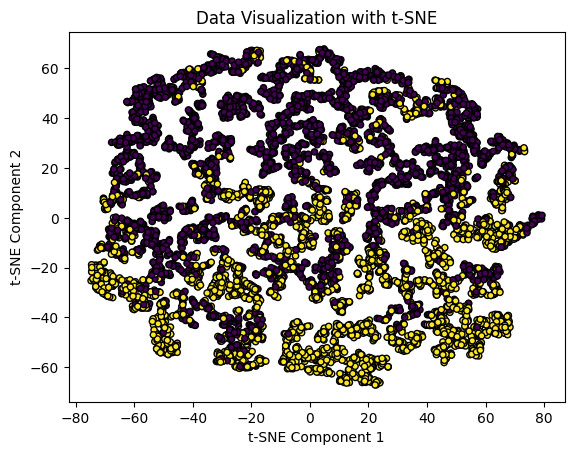

In [37]:
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)  # 'High' -> 1, 'Low' -> 0

tsne = TSNE(n_components=2, random_state=42)
X1_tsne = tsne.fit_transform(X1)

# Scatter plot of the t-SNE-reduced data
plt.scatter(X1_tsne[:, 0], X1_tsne[:, 1], c=y_encoded, s=20, edgecolors="k")
plt.title("Data Visualization with t-SNE")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

However, as we can see from the visualization above, it is possible that the model may benefit from non-linear separation.

In [ ]:
model_2_lin = SVC(kernel = 'rbf')

model_2_lin.fit(X_train1, y_train)

y_pred_rbf = model_2_lin.predict(X_test1)

In [ ]:
print("Radial SVC 1 Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_rbf))
print("Precision:", precision_score(y_test, y_pred_rbf, pos_label='High'))
print("Recall:", recall_score(y_test, y_pred_rbf, pos_label='High'))

Linear SVC 1 Performance:
Accuracy: 0.8562783661119516
Precision: 0.8918169209431346
Recall: 0.8516556291390729


Interestingly, both variants of the model perform similarly (although the linear model performs marginally better in terms of recall whereas the radial model performs marginally better in terms of recall), suggesting that there is liner separation occurring within the feature-space that fit a linear decision boundary.

# Support Vector Machine Model 2

Following the approach in assignment 2, we will now generate a model predicting exam score category classification based on external factors (teacher quality, parental involvement, and family income).

In [46]:
X2 = dataset[['Teacher_Quality', 'Parental_Involvement', 'Family_Income']]
y = dataset['Exam_Score_Category'] 

In [47]:
X_train2, X_test2, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)

In [49]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Fit and transform on y_train
y_test_encoded = label_encoder.transform(y_test)  # Transform y_test

# Step 3: Identify categorical columns in X_train2
categorical_columns = X_train2.select_dtypes(include=['object']).columns

# Step 4: Create a preprocessing pipeline for categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns)
    ],
    remainder='passthrough'  # Keep other columns as is
)

# Step 5: Create the pipeline with the preprocessor and classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel = 'linear'))
])

# Step 6: Fit the pipeline on the training data
pipeline.fit(X_train2, y_train_encoded)

# Step 7: Make predictions and evaluate
y_pred2 = pipeline.predict(X_test2)

print("\nDecision Tree Model 2 Performance (External Factors):")
print("Accuracy:", accuracy_score(y_test_encoded, y_pred2))

# Get the label for "High" (adjust if necessary for your classes)
high_label = label_encoder.transform(['High'])[0]
print("Precision:", precision_score(y_test_encoded, y_pred2, pos_label=high_label))
print("Recall:", recall_score(y_test_encoded, y_pred2, pos_label=high_label))


Decision Tree Model 2 Performance (External Factors):
Accuracy: 0.5922844175491679
Precision: 0.6022727272727273
Recall: 0.8423841059602649


This model performs similarly to the decision tree generated in the previous assignment; however, we can see slight improvements in all metrics assessed, indicating that, while the rates of correct predictions in this model are mediocre, this model is superior to the decision tree previously created with the same features used. Interestingly, recall saw the largest increase in performance (from .73 to .84 in this model), suggesting that this model the true positive rate of this model saw the greatest improvements compared to the decision tree model. 

However, perhaps this model would benefit from non-linear approaches.

In [58]:
pipeline_rbf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel = 'rbf'))
])

# Step 6: Fit the pipeline on the training data
pipeline_rbf.fit(X_train2, y_train_encoded)

# Step 7: Make predictions and evaluate
y_pred2_rbf = pipeline_rbf.predict(X_test2)

print("\nDecision Tree Model 2 Performance (External Factors):")
print("Accuracy:", accuracy_score(y_test_encoded, y_pred2_rbf))

# Get the label for "High" (adjust if necessary for your classes)
high_label = label_encoder.transform(['High'])[0]
print("Precision:", precision_score(y_test_encoded, y_pred2_rbf, pos_label=high_label))
print("Recall:", recall_score(y_test_encoded, y_pred2_rbf, pos_label=high_label))


Decision Tree Model 2 Performance (External Factors):
Accuracy: 0.5741301059001512
Precision: 0.6016949152542372
Recall: 0.752317880794702


This approach did not improve the model, which suggests that a linear separation is the more appropriate option for these data.